In [1]:
from array import array
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"

import numpy as np
import struct
import matplotlib.pyplot as plt
from typing import Dict, List
import random
from multiprocessing import Pool

f1 = open("./archive/train-images.idx3-ubyte", "rb")
struct.unpack(">IIII", f1.read(16))
imgs1 = np.array(array("B", f1.read()), dtype=np.uint32).reshape((-1, 28, 28))

f2 = open("archive/t10k-images.idx3-ubyte", "rb")
struct.unpack(">IIII", f2.read(16))
imgs2 = np.array(array("B", f2.read()), dtype=np.uint32).reshape((-1, 28, 28))

imgs = np.concat((imgs1, imgs2), axis=0)
print(imgs.shape)


(70000, 28, 28)


(70000, 28, 28)


/home/aman/miniconda3/envs/bm/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Casting input data from float128 to float64 for imshow.
  fig.canvas.print_figure(bytes_io, **kw)


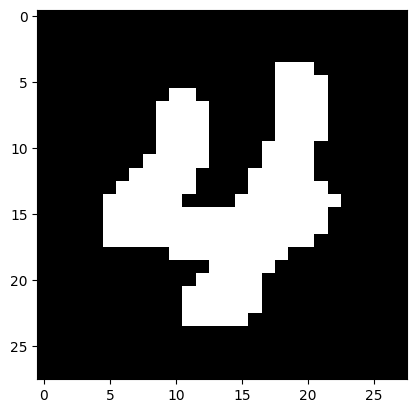

In [2]:
from array import array
import numpy as np
import struct
import matplotlib.pyplot as plt
from typing import Dict

f1 = open("archive/train-images.idx3-ubyte", "rb")
struct.unpack(">IIII", f1.read(16))
imgs1 = np.array(array("B", f1.read()), dtype=np.bool).reshape((-1, 28, 28)).astype(np.float128)

f2 = open("archive/t10k-images.idx3-ubyte", "rb")
struct.unpack(">IIII", f2.read(16))
imgs2 = np.array(array("B", f2.read()), dtype=np.bool).reshape((-1, 28, 28)).astype(np.float128)

imgs = np.concat((imgs1, imgs2), axis=0)
print(imgs.shape)

plt.imshow(random.choice(imgs), cmap="gray")
plt.show()

In [3]:
N_ATOMS = 100
COOLING_RATE = 0.001
THRESHOLD_INCREASE_RATE = 0.001
DELTA_SIGMA = 0.01

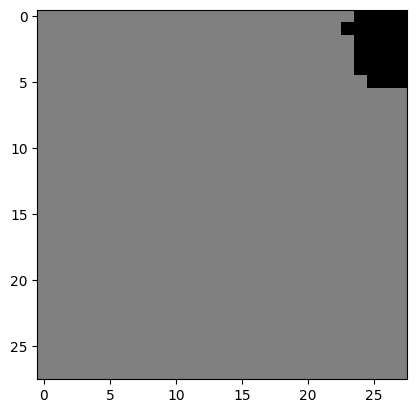

In [4]:
class AtomNode:
    def __init__(self, vector):
        self.vector = vector
        self.strength = random.normalvariate()
        self.active = 0
        self.input = 0
        self.weights = None

    def update(self, temp):
        prob = 1 / (1 + np.exp(-self.input / temp))
        self.active = random.choices([0, 1], [1-prob, prob])[0]

    def generate_weights(self):
        self.weights = self.vector * (self.strength / np.count_nonzero(self.vector))

    def calculate_input(self, representation_vector, threshold):
        self.generate_weights()
        self.input = np.dot(self.weights.flat, representation_vector.flat) - self.strength * threshold


xs = np.array([[i for i in range(28)] for _ in range(28)])
ys = np.array([[j for _ in range(28)] for j in range(28)])

def atomize(image, radius):
    x, y = random.randint(0, 28), random.randint(0, 28)

    ins = ((xs - x) ** 2 + (ys - y) ** 2) ** 0.5 <= radius
    image[image == 0] = -1
    atom_vector = np.multiply(image, ins)
    atom_vector[ins == 0] = 0

    return AtomNode(atom_vector)

img = random.choice(imgs)
plt.imshow(atomize(img, 5).vector, cmap="gray", vmin=-1, vmax=1)
plt.show()

In [5]:
def hk(representation_vector, atom: AtomNode, threshold):
    return np.dot(representation_vector.flat, atom.vector.flat) / np.count_nonzero(atom.vector) - threshold

In [6]:
class FeatureSet:
    def __init__(self, fixed_vector):
        self.vector = np.zeros((28, 28))
        self.input = np.zeros((28, 28))
        self.fixed = fixed_vector

    def update(self, temp):
        probs = 1 / (1 + np.exp(-self.input / temp))
        self.vector = (np.random.uniform(0., 1., size=(28, 28)) < probs).astype(float)
        self.vector[self.fixed != 0] = self.fixed[self.fixed != 0]

    def calculate_input(self, atoms: List[AtomNode]):
        self.input = 2 * sum([atom.vector * atom.active for atom in atoms])

In [7]:
class AtomSet:
    def __init__(self):
        atoms = random.choices(list(imgs), k=N_ATOMS)
        self.atoms = [atomize(atom, 28) for atom in atoms]

    def learn_example(self, example):
        for atom in self.atoms:
            if hk(example, atom, 0.5) > 0:
                atom.strength += DELTA_SIGMA

    def train(self, n=1000):
        print("training")
        for i in range(n):
            self.learn_example(random.choice(imgs))
            
    def dampen(self, n=1000):
        print("dampening")
        f = FeatureSet(np.zeros((28, 28)))

        for i in range(n):
            f.calculate_input(self.atoms)
            f.update(1)
            
            for atom in self.atoms:
                atom.calculate_input(f.vector, 0.5)
                atom.update(1)
                if hk(f.vector, atom, 0.5) > 0:
                    atom.strength -= DELTA_SIGMA

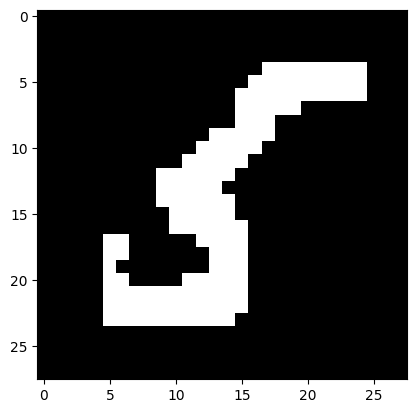

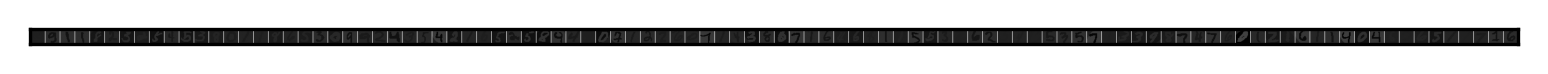

In [8]:
atoms = AtomSet()

img = random.choice(imgs)
atom = random.choice(atoms.atoms)

grid = np.zeros((28, 28 * N_ATOMS))
img = random.choice(imgs)

for i, atom in enumerate(atoms.atoms):
    h = hk(img, atom, 0.)
    grid[:, i * 28: (i + 1) * 28] = atom.vector * h
    grid[:, i * 28] = 1

plt.imshow(img, cmap="gray")
plt.show()

_, ax = plt.subplots(1, 1, dpi=300)
ax.imshow(grid, cmap="gray")
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [9]:
def Hk(representation_vector, atoms: List[AtomNode]):
    return sum([atom.strength * atom.active * hk(representation_vector, atom) for atom in atoms])

In [10]:
for i in range(50):
    print(i)
    atoms.train(n=1000)
    atoms.dampen(n=1000)

0
training
dampening
1
training
dampening
2
training
dampening
3
training
dampening
4
training
dampening
5
training
dampening
6
training
dampening
7
training
dampening
8
training
dampening
9
training
dampening
10
training
dampening
11
training
dampening
12
training
dampening
13
training
dampening
14
training
dampening
15
training
dampening
16
training
dampening
17
training
dampening
18
training
dampening
19
training
dampening
20
training
dampening
21
training
dampening
22
training
dampening
23
training
dampening
24
training
dampening
25
training
dampening
26
training
dampening
27
training
dampening
28
training
dampening
29
training
dampening
30
training
dampening
31
training
dampening
32
training
dampening
33
training
dampening
34
training
dampening
35
training
dampening
36
training
dampening
37
training
dampening
38
training
dampening
39
training
dampening
40
training
dampening
41
training
dampening
42
training
dampening
43
training
dampening
44
training
dampening
45
training
dampenin

In [11]:
import dearpygui.dearpygui as dpg

a = AtomSet()
image = random.choice(imgs)
f = FeatureSet(atomize(image, 5).vector)
# f = FeatureSet(np.zeros((28, 28)))
t = 10
threshold = 0

CANVAS_SIZE = 560

dpg.create_context()

with dpg.window():
    dpg.set_primary_window(dpg.last_item(), True)

    with dpg.drawlist(width=CANVAS_SIZE, height=CANVAS_SIZE):
        for i in range(28):
            for j in range(28):
                dpg.draw_circle((i * 20, j * 20), 10, tag=f"node_{i}_{j}")

dpg.create_viewport(width=560, height=560)
dpg.setup_dearpygui()
dpg.show_viewport()

while dpg.is_dearpygui_running():
    f.calculate_input(a.atoms)
    f.update(t)
    for atom in a.atoms:
        atom.calculate_input(f.vector, threshold)
        atom.update(t)

    if t > 0.05:
        t -= COOLING_RATE
    if threshold + THRESHOLD_INCREASE_RATE < 1:
        threshold += THRESHOLD_INCREASE_RATE
    print(t, threshold)

    for i in range(28):
        for j in range(28):
            color = (0, 0, 255) if f.fixed[i, j] else [max(0, f.vector[i, j]) * 255] * 3
            dpg.configure_item(f"node_{i}_{j}", fill=[max(0, f.vector[i, j]) * 255] * 3, color=color)
    dpg.render_dearpygui_frame()

dpg.destroy_context()

9.999 0.001
9.998000000000001 0.002
9.997000000000002 0.003
9.996000000000002 0.004
9.995000000000003 0.005
9.994000000000003 0.006
9.993000000000004 0.007
9.992000000000004 0.008
9.991000000000005 0.009000000000000001
9.990000000000006 0.010000000000000002
9.989000000000006 0.011000000000000003
9.988000000000007 0.012000000000000004
9.987000000000007 0.013000000000000005
9.986000000000008 0.014000000000000005
9.985000000000008 0.015000000000000006
9.984000000000009 0.016000000000000007
9.98300000000001 0.017000000000000008
9.98200000000001 0.01800000000000001
9.98100000000001 0.01900000000000001
9.980000000000011 0.02000000000000001
9.979000000000012 0.02100000000000001
9.978000000000012 0.022000000000000013
9.977000000000013 0.023000000000000013
9.976000000000013 0.024000000000000014
9.975000000000014 0.025000000000000015
9.974000000000014 0.026000000000000016
9.973000000000015 0.027000000000000017
9.972000000000016 0.028000000000000018
9.971000000000016 0.02900000000000002
9.9700000